In [1]:
%matplotlib inline
import sys
import math
import numpy as np
import pandas
from matplotlib import pyplot
from mosthosts_desi import MostHostsDesi

## Finding all DESI observations of MostHosts objects

The MostHostsDesi class will match all of the RA/Dec from Mosthosts to the daily tables of observations from DESI.  It builds a (somewhat complicated) Pandas datastructure with all of the matches, and then writes that data structure to a csv file.  Look at that file for documentation on how it works.

In [2]:
# To actually use this, you'll need to pass a database user and password.
# See the docstring on MostHostsDesi.__init__ for more information.
# Release can be one of : daily , everest , fuji , guadalupe , fujilupe
#  (fujilupe is the union of fuji and guadalupe)
# By default, this reads mosthosts_desi_{release}.csv from the local
#   directory.  Set force_regen=True to make it rebuild that file.
subset = "daily"
mhd = MostHostsDesi( release=subset, force_regen=True)

[2022-07-12 12:26:42,364 - INFO] - Loading mosthosts table...
[2022-07-12 12:26:43,523 - INFO] - ...mosthosts table loaded.
[2022-07-12 12:26:43,524 - INFO] - Rebuilding info for release daily
[2022-07-12 12:26:43,539 - INFO] - Sending q3c_join query for release daily
[2022-07-12 12:26:43,770 - INFO] - ...temporary table has 6265 rows, 6265 including a desi observation.
[2022-07-12 12:26:43,771 - INFO] - Getting night/redshift/type info
[2022-07-12 12:26:44,066 - INFO] - ...done getting night/redshift/type info, got 7263 rows.
[2022-07-12 12:26:44,639 - INFO] - 5697 of 7263 redshifts left after keeping only latest night
[2022-07-12 12:26:44,640 - INFO] - Building hazdf...
[2022-07-12 12:26:44,703 - INFO] - Building df...
[2022-07-12 12:26:52,719 - INFO] - Done generating dataframes.
[2022-07-12 12:26:53,191 - INFO] - mosthosts_desi_daily.csv and mosthosts_desi_daily_desiobs.csv written.


In [3]:
# Print out some statistics
print( f'...as of when the csv and pkl files were last regenerated:' )
print( f'{len(mhd.df)} entries in the MostHosts database' )
print( f'{len(mhd.df.groupby("snname"))} different SNe/AGN in MostHosts database' )
print( f'{mhd.df["z"].notnull().sum()} hosts have at least one DESI zwarn=0 redshift' )
print( f'{len( mhd.df[ mhd.df["z"].notnull() ].groupby( "snname" ) )} SNe/AGN have at least one host observed by DESI' )
# I put this here as a self-consistency check between my two dataframes
print( f'The same number again: {len( mhd.haszdf[ mhd.haszdf["zwarn"]==0 ].reset_index().groupby( "snname" ) )}' )

# Make a dataframe that's like df, but that omits all QSOs and that all have at least one redshift
print( '' )
justsne = mhd.haszdf[ mhd.haszdf['zwarn']==0 ]
justsne = justsne[ justsne['program'].apply( lambda x: 'QSO' not in x ) ]
print( f'{len( justsne.reset_index().groupby( ["snname", "index"] ))} non-QSO MostHosts have at least one DESI observation' )
print( f'{len( justsne.reset_index().groupby( "snname" ))} SNe (i.e. non-QSO targets) have at least one host observed by DESI' )


...as of when the csv and pkl files were last regenerated:
20174 entries in the MostHosts database
14958 different SNe/AGN in MostHosts database
4654 hosts have at least one DESI zwarn=0 redshift
4493 SNe/AGN have at least one host observed by DESI
The same number again: 4493

3751 non-QSO MostHosts have at least one DESI observation
3590 SNe (i.e. non-QSO targets) have at least one host observed by DESI


In [4]:
# If you want to figure out which supernovae have multiple hosts, you can poke at the mhd.df dataframe similar to the following

origtablehostcount = mhd.df.reset_index().groupby( "snname" ).count()["index"]
for i in range( 1, 8 ):
    print( f'{(origtablehostcount == i).sum()} candidates in the mosthosts table have {i} hosts' )
# print( f'The candidates with 3 observed hosts are: {origtablehostcount[origtablehostcount == 5].index.values}' )

print( '' )

obshostcount = mhd.df[ mhd.df['z'].notnull() ].reset_index().groupby( "snname" ).count()["index"]
for i in range( 1, 8 ):
    print( f'{(obshostcount == i).sum()} candidates have {i} hosts observed by DESI with zwarn=0' )

11240 candidates in the mosthosts table have 1 hosts
2367 candidates in the mosthosts table have 2 hosts
1217 candidates in the mosthosts table have 3 hosts
123 candidates in the mosthosts table have 4 hosts
10 candidates in the mosthosts table have 5 hosts
0 candidates in the mosthosts table have 6 hosts
1 candidates in the mosthosts table have 7 hosts

4345 candidates have 1 hosts observed by DESI with zwarn=0
136 candidates have 2 hosts observed by DESI with zwarn=0
11 candidates have 3 hosts observed by DESI with zwarn=0
1 candidates have 4 hosts observed by DESI with zwarn=0
0 candidates have 5 hosts observed by DESI with zwarn=0
0 candidates have 6 hosts observed by DESI with zwarn=0
0 candidates have 7 hosts observed by DESI with zwarn=0


In [5]:
# Match mosthosts to main desi targets
mhd.find_main_targets( force_regen=False )

print( f"{len(mhd.maintargets.groupby( ['spname', 'index'] ).first())} "
       f"of {len(mhd.df)} mosthosts show up in DESI main targets" )

subdf = mhd.maintargets[ mhd.maintargets['bgs_target'] > 0 ]
print( f"{len(subdf.groupby( ['spname', 'index'] ).first())} "
       f"of {len(mhd.df)} mosthosts have a bgs_target > 0" )

_justsnedf = mhd.df[ ['QSO' not in p for p in mhd.df['program'] ] ]
_justsnemaintargets = mhd.maintargets[ [ 'QSO' not in p for p in mhd.maintargets['program'] ] ]

print( f"{len(_justsnemaintargets.groupby( ['spname', 'index'] ).first())} "
       f"of {len(_justsnedf)} non-QSO mosthosts show up in DESI main targets" )
subdf = _justsnemaintargets[ _justsnemaintargets['bgs_target'] > 0 ]
print( f"{len(subdf.groupby( ['spname', 'index'] ).first())} "
       f"of {len(_justsnedf)} non-QSO mosthosts have a bgs_Target > 0" )

# A long way to do subtraction

_justqsodf = mhd.df[ ['QSO' in p for p in mhd.df['program'] ] ]
_justqsomaintargets = mhd.maintargets[ ['QSO' in p for p in mhd.maintargets['program'] ] ]
print( f"{len(_justqsomaintargets.groupby( ['spname', 'index'] ).first())} "
       f"of {len(_justqsodf)} QSO mosthosts show up in DESI main targets" )
subdf = _justqsomaintargets[ _justqsomaintargets['bgs_target'] > 0 ]
print( f"{len(subdf.groupby( ['spname', 'index'] ).first())} "
       f"of {len(_justqsodf)} QSO mosthosts have a bgs_Target > 0" )



[2022-07-12 12:26:59,993 - INFO] - MainTargets info read from mosthosts_desi_maintargets.pkl


12396 of 20174 mosthosts show up in DESI main targets
10586 of 20174 mosthosts have a bgs_target > 0
10656 of 18173 non-QSO mosthosts show up in DESI main targets
10353 of 18173 non-QSO mosthosts have a bgs_Target > 0
1740 of 2001 QSO mosthosts show up in DESI main targets
233 of 2001 QSO mosthosts have a bgs_Target > 0


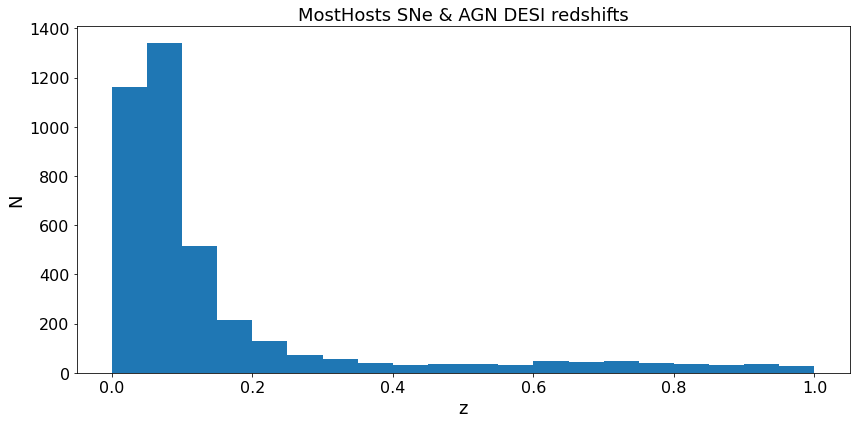

In [6]:
# Make a histogram of independent supernova z and AGN.  The host z might not be the right one, as
#   the plot just naively grabs the first host listed for each SN.

subframe = mhd.df[ mhd.df['z'].notnull() ].groupby( 'snname' ).agg('first')

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe & AGN DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()
fig.savefig( f'mosthostsz_{subset}.svg' )


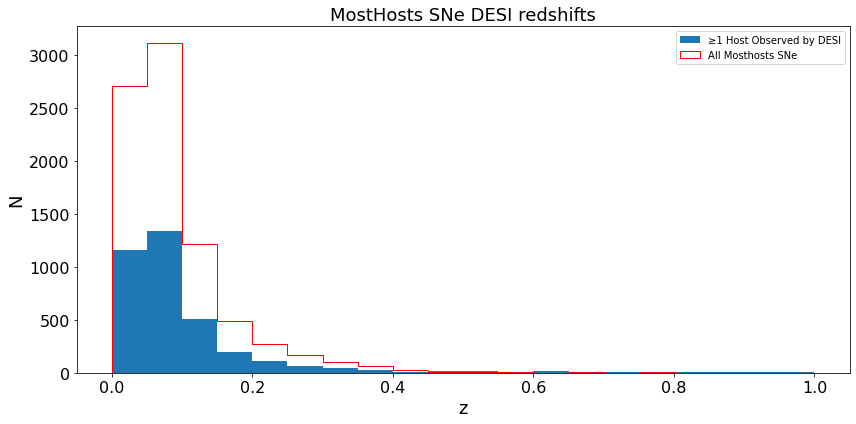

In [7]:
# Make a histogram of *independent* supernova zs.  I'm just going to take the first measurement
#  for each supernova... which may well not be the right one!

subframe = justsne.groupby( 'snname' ).agg('first')

allmhjustsne = mhd.df.groupby( 'snname' ).agg('first')
allmhjustsne = allmhjustsne[ allmhjustsne['program'].apply( lambda x: 'QSO' not in x ) ]

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20, label="≥1 Host Observed by DESI" )
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )

ax.hist( allmhjustsne['sn_z'], range=(0, 1), bins=20, histtype='step', color='red', label="All Mosthosts SNe" )

ax.legend()

fig.show()
fig.savefig( f'mosthosts_justsnez_{subset}.svg' )


/tmp/ipykernel_34471/3901605094.py:9: RuntimeWarning: invalid value encountered in true_divide
  ax.step( allbins[:-1], obshist/allhist, where='post', color='blue' )


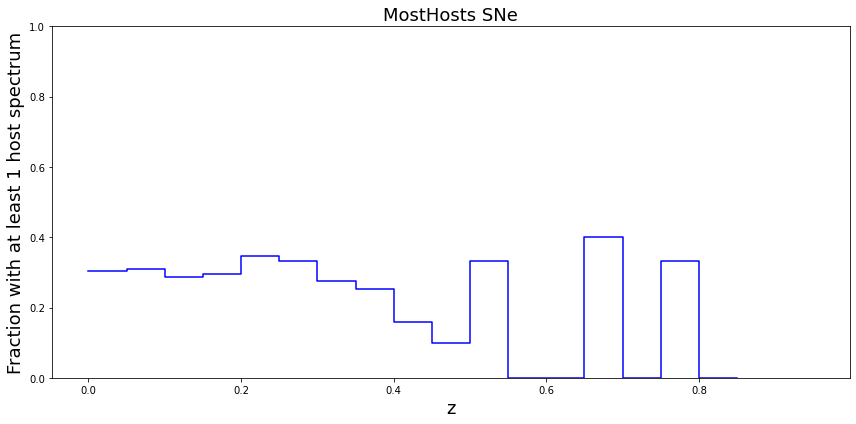

In [8]:
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1)
obshist, obsbins = np.histogram( subframe['sn_z'], range=(0,1), bins=20 )
allhist, allbins = np.histogram( allmhjustsne['sn_z'], range=(0,1), bins=20 )
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('Fraction with at least 1 host spectrum', fontsize=18)
ax.set_title( 'MostHosts SNe', fontsize=18 )
ax.set_ylim( 0, 1 )
ax.step( allbins[:-1], obshist/allhist, where='post', color='blue' )
fig.show()


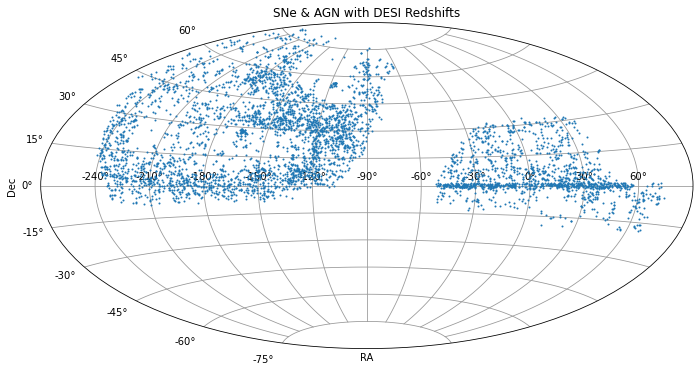

In [9]:
# Plot them on the sky

subframe = mhd.df[ mhd.df['z'].notnull() ].groupby( 'snname' ).agg('first')


fig = pyplot.figure( figsize=(12,6) )
ax = fig.add_subplot(1, 1, 1, projection='aitoff' )
# I want to plot the aitoff projection not having 0 at the center
# I don't know if there's a simple argument to give to the axes for
# this, so I'll manually offset my RAs, and then manually edit the
# tick labels, to offset by raoff degrees.
raoff = 90
ras = ( subframe['ra'].values + raoff ) * math.pi/180.
ras[ ras < -math.pi ] = ras[ ras < -math.pi ] + 2*math.pi
ras[ ras >= math.pi ] = ras[ ras >= math.pi ] - 2*math.pi
ax.set_longitude_grid( 30 )
ax.set_latitude_grid( 15 )
ax.grid( which='major', color='#999999' )
ax.plot( ras, subframe['dec'].values*math.pi/180., linestyle='None', marker='o', markersize=1 )
fig.canvas.draw()
labels = [ f'{float(lab.get_text()[:-1])-raoff:.0f}°' for lab in ax.get_xticklabels() ]
ax.set_xticklabels( labels )
# Remove the 75° label so it doesn't overlap the title.
# THere's probably a more elegant way to do this.
labels = [ lab for lab in ax.get_yticklabels()[:-1] ] + ['']
ax.set_yticklabels( labels )
ax.set_xlabel( "RA" )
ax.set_ylabel( "Dec" )
ax.set_title( "SNe & AGN with DESI Redshifts" )
fig.show()
fig.savefig( f'mosthostdesiz_skydist_{subset}.svg' )

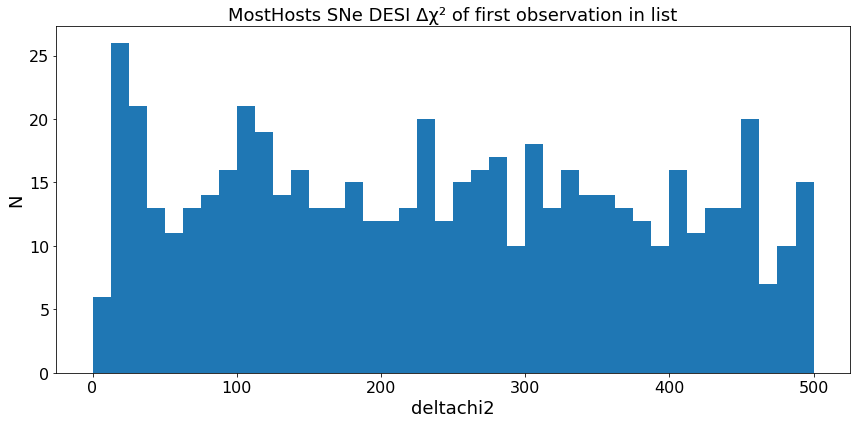

In [10]:
subframe = justsne.groupby( 'snname' ).agg('first')

fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['deltachi2'].values, range=(0,500), bins=40)
ax.set_xlabel('deltachi2', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI Δχ² of first observation in list', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()


## Stuff below is just futzing around with the tables to subset by name, etc.

In [47]:
subframe = justsne.groupby( 'snname' ).agg('first')
dexes = subframe.index.values
ztfobjs = subframe[ [ it[0:3]=='ZTF' for it in dexes ] ]
# I know I could have done a pandas count something something,
# but I might want this subframe later.
print( f"There are {len(ztfobjs)} SNe with DESI-observed hosts whose names start with \"ZTF\"" )

There are 2039 SNe with DESI-observed hosts whose names start with "ZTF"


In [48]:
# Save these ZTF supernovae to a file for my own sinister purposes
ztfobjs[ ['z', 'ra', 'dec' ] ]
with open( "cheesyfujiztflist.txt", "w" ) as ofp:
    for i in range(len(ztfobjs)):
        ofp.write( f"{ztfobjs.reset_index()['snname'][i]} {ztfobjs.reset_index()['ra'][i]} {ztfobjs.reset_index()['dec'][i]}\n" )
        

In [49]:
ztfobjs['program'].unique()

array(['SNe_Ia', 'ZTFmarshal', 'SNe_Ia/RCF/ZTFmarshal',
       'SNe_Ia/ZTFmarshal', 'RCF', 'RCF/ZTFmarshal', 'SNe_Ia/RCF',
       'IIps/ZTFmarshal', 'RCF/IIps/ZTFmarshal', 'SNe_Ia/IIps/ZTFmarshal',
       'SNe_Ia/RCF/Anna', 'SNe_Ia/RCF/IIps/ZTFmarshal', 'one_shot_dL',
       'Anna/ZTFmarshal', 'RCF/RCF/RCF/ZTFmarshal/ZTFmarshal'],
      dtype=object)

In [50]:
# ztfobjs['program'].values is an object, not a string, so this is convolted
ztfsne = ztfobjs[ np.char.find( np.array( ztfobjs['program'].values, dtype=str ), 'SNe_Ia' ) >= 0 ]
print( f'There are {len(ztfsne)} SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"' )

There are 878 SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"


In [52]:
justptf = justsne[ justsne['ptfiptf_name'] != 'None' ]
print( f'There are {len(justptf)} SNe with a non-"None" ptfiptf_name' )

There are 757 SNe with a non-"None" ptfiptf_name


(-0.01, 0.01)

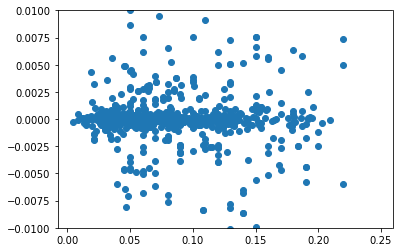

In [55]:
pyplot.plot( justptf['sn_z'], justptf['z']-justptf['sn_z'], linestyle='', marker='o' )
pyplot.ylim( -0.01, 0.01 )

In [17]:

pandas.options.display.max_rows = 500
justptf[ ['ptfiptf_name', 'ra', 'dec', 'z'] ]

ptfiptf_name  \
snname index targetid            tileid petal night                   
09alu  1     39633304558764813   174    4     20210405     PTF09alu   
                                 182    4     20210506     PTF09alu   
09bad  2     39633339597983311   318    6     20210501     PTF09bad   
09iag  1     39627927029023382   148    6     20210407     PTF09iag   
                                 153    6     20210504     PTF09iag   
                                 156    6     20210508     PTF09iag   
09idu  1     39633300511263781   81057  2     20210324     PTF09idu   
09ps   1     39633332819987400   310    6     20210410      PTF09ps   
09si   1     39633132084789477   337    0     20210410      PTF09si   
                                 343    0     20210430      PTF09si   
09uj   1     39633300964248355   179    4     20210428      PTF09uj   
                                 183    5     20210509      PTF09uj   
                                 184    5     20210529      PTF09uj   
10bci  1     39633345692304588   81066  5     20210326     PTF10bci   
10bzf  1     39633332178260069   81058  2     20210324     PTF10bzf   
10ctd  1     39627835551257442   17     2     20210429     PTF10ctd   
                                 21     3     20210503     PTF10ctd   
                                 80742  1     20210328     PTF10ctd   
10cua  1     39633315510094658   307    8     20210419     PTF10cua   
       2     39633315510094644   306    8     20210417     PTF10cua   
10cwp  1     39627775660789402   445    0     20210513     PTF10cwp   
       2     39627775660789352   43     0     20210415     PTF10cwp   
                                 49     0     20210529     PTF10cwp   
10fej  1     39633308400748201   310    1     20210410     PTF10fej   
                                 317    1     20210430     PTF10fej   
10fjh  1     39632966892130347   395    2     20210430     PTF10fjh   
10hmd  1     39632986315950484   200    5     20210506     PTF10hmd   
10htz  1     2305843022014712506 80955  8     20210425     PTF10htz   
10mtd  1     39627908968352897   153    8     20210504     PTF10mtd   
10vh   1     39627817998091981   66     5     20210406      PTF10vh   
10wxp  1     39632991722410078   391    5     20210410     PTF10wxp   
                                 395    5     20210430     PTF10wxp   
                                 399    5     20210508     PTF10wxp   
                                 400    5     20210529     PTF10wxp   
11aqu  1     39633318278336562   81057  3     20210324     PTF11aqu   
11daj  1     39627841603637686   15     8     20210412     PTF11daj   
11dwn  1     39632976375451507   199    3     20210505     PTF11dwn   
11ftp  1     39628493738213744   80616  5     20201223     PTF11ftp   
11gcc  1     39628465154031779   122    4     20210417     PTF11gcc   
                                 124    4     20210430     PTF11gcc   
11gdh  1     39628438620868323   120    9     20210407     PTF11gdh   
11go   1     39633304143529164   81057  8     20210324      PTF11go   
11kdc  1     39628457105163147   80617  6     20201223     PTF11kdc   
11lmy  1     39633339593785737   307    5     20210419     PTF11lmy   
11qqj  1     39627805356458202   13     1     20210407     PTF11qqj   
11vb   1     39628427854090190   80664  3     20210402      PTF11vb   
12awi  1     39627835576419368   12     8     20210406     PTF12awi   
12bmr  1     39633289694150935   81067  7     20210327     PTF12bmr   
12cgb  1     39633145338793061   365    4     20210411     PTF12cgb   
12csi  1     39632946772052478   393    1     20210419     PTF12csi   
12dnn  1     39633118675600608   589    9     20210506     PTF12dnn   
                                 591    9     20210509     PTF12dnn   
                                 592    9     20210510     PTF12dnn   
                                 595    9     20210529     PTF12dnn   
12eaw  2     39632981379254108   203    6     20210412     PTF12eaw   
        

In [18]:
mhd.haszdf

ra  \
snname                     index targetid            tileid petal night                  
09alu                      1     39633304558764813   174    4     20210405  214.572816   
                                                     182    4     20210506  214.572816   
09bad                      2     39633339597983311   310    6     20210410  244.010525   
                                                     318    6     20210501  244.010525   
09iag                      1     39627927029023382   148    6     20210407  210.656536   
...                                                                                ...   
snatel1615/SN2008r3/ROTSE3 1     39628427900225097   128    1     20210507  194.142458   
                                 2305843020118892651 131    1     20210406  194.142458   
                                                     133    1     20210415  194.142458   
                           9     39628427900225839   119    1     20210504  194.176350   
unknown-80                 1     39627779326609544   80637  1     20210221   38.059600   

                                                                                  dec  \
snname                     index targetid            tileid petal night                 
09alu                      1     39633304558764813   174    4     20210405  53.788987   
                                                     182    4     20210506  53.788987   
09bad                      2     39633339597983311   310    6     20210410  56.346198   
                                                     318    6     20210501  56.346198   
09iag                      1     39627927029023382   148    6     20210407   5.747376   
...                                                                               ...   
snatel1615/SN2008r3/ROTSE3 1     39628427900225097   128    1     20210507  27.538944   
                                 2305843020118892651 131    1     20210406  27.538944   
                                                     133    1     20210415  27.538944   
                           9     39628427900225839   119    1     20210504  27.509850   
unknown-80                 1     39627779326609544   80637  1     20210221  -0.308103   

                                                                            pmra  \
snname                     index targetid            tileid petal night            
09alu                      1     39633304558764813   174    4     20210405   0.0   
                                                     182    4     20210506   0.0   
09bad                      2     39633339597983311   310    6     20210410   0.0   
                                                     318    6     20210501   0.0   
09iag                      1     39627927029023382   148    6     20210407   0.0   
...                                                                          ...   
snatel1615/SN2008r3/ROTSE3 1     39628427900225097   128    1     20210507   0.0   
                                 2305843020118892651 131    1     20210406   0.0   
                                                     133    1     20210415   0.0   
                           9     39628427900225839   119    1     20210504   0.0   
unknown-80                 1     39627779326609544   80637  1     20210221   0.0   

                                                                            pmdec  \
snname                     index targetid            tileid petal night             
09alu                      1     39633304558764813   174    4     20210405    0.0   
                                                     182    4     20210506    0.0   
09bad                      2     39633339597983311   310    6     20210410    0.0   
                                                     318    6     20210501    0.0   
09iag                      1     39627927029023382   148    6     20210407    0.0   
...                                                                

In [19]:
# Get a count of how many times each host has zwarn=0 observations
numobs = mhd.haszdf.groupby(level=[0,1]).aggregate('count').rename( {'ra': 'numobs'}, axis=1 )['numobs']

In [20]:
numobs[numobs>3]

snname                      index
10ctd                       1        4
10wxp                       1        4
12dnn                       1        5
13adc                       1        5
AGN_1070                    1        4
AGN_1520                    1        4
AGN_196                     1        4
AGN_222                     1        4
AGN_355                     1        5
AGN_640                     1        4
AGN_761                     1        5
AGN_783                     1        8
AGN_911                     1        5
AGN_95                      1        4
SN2001cg                    1        4
SN2006bz                    1        4
ZTF18aabedfu                1        4
ZTF18abfgtcf                1        5
ZTF19aakizps                1        4
ZTF19aamgnnr                1        4
ZTF20aafcjln                1        4
snatel1615/SN2008r3/ROTSE3  1        7
Name: numobs, dtype: int64

In [21]:
mhd.haszdf.xs( 'ZTF18aavniyw', level=0 )

ra        dec  pmra  \
index targetid            tileid petal night                                   
1     39633274766623836   81064  4     20210327  172.876147  51.628972   0.0   
      2305843015459014979 81088  6     20210404  172.876147  51.628972   0.0   

                                                 pmdec  ref_epoch  override  \
index targetid            tileid petal night                                  
1     39633274766623836   81064  4     20210327    0.0        0.0     False   
      2305843015459014979 81088  6     20210404    0.0        0.0     False   

                                                hemisphere       sn_ra  \
index targetid            tileid petal night                             
1     39633274766623836   81064  4     20210327      north  172.875062   
      2305843015459014979 81088  6     20210404      north  172.875062   

                                                    sn_dec   sn_z  ...  \
index targetid            tileid petal night                       ...   
1     39633274766623836   81064  4     20210327  51.629381  0.055  ...   
      2305843015459014979 81088  6     20210404  51.629381  0.055  ...   

                                                iau_name  ptfiptf_name  \
index targetid            tileid petal night                             
1     39633274766623836   81064  4     20210327     None          None   
      2305843015459014979 81088  6     20210404     None          None   

                                                    spname         z  \
index targetid            tileid petal night                           
1     39633274766623836   81064  4     20210327  AT2018ceb  0.054983   
      2305843015459014979 81088  6     20210404  AT2018ceb  0.055008   

                                                     zerr zwarn          chi2  \
index targetid            tileid petal night                                    
1     39633274766623836   81064  4     20210327  0.000005   0.0  25954.748366   
      2305843015459014979 81088  6     20210404  0.000033   0.0   8408.902428   

                                                    deltachi2  spectype  \
index targetid            tileid petal night                              
1     39633274766623836   81064  4     20210327  29584.433906    GALAXY   
      2305843015459014979 81088  6     20210404   1263.968939    GALAXY   

                                                 subtype  
index targetid            tileid petal night              
1     39633274766623836   81064  4     20210327           
      2305843015459014979 81088  6     20210404           

[2 rows x 23 columns]

In [22]:
mhd.haszdf[ mhd.haszdf.spname=='2004hx' ]

,,,,,,ra,dec,pmra,pmdec,ref_epoch,override,hemisphere,sn_ra,sn_dec,sn_z,...,iau_name,ptfiptf_name,spname,z,zerr,zwarn,chi2,deltachi2,spectype,subtype
snname,index,targetid,tileid,petal,night,,,,,,,,,,,,,,,,,,,,,


In [23]:
mhd.df[ mhd.df.spname=="2004hx" ]

ra       dec  pmra  pmdec  ref_epoch  override  \
snname index                                                          
2004hx 1      40.302882 -0.877206   0.0    0.0        0.0     False   
       2      40.304096 -0.876849   0.0    0.0        0.0     False   

             hemisphere    sn_ra    sn_dec    sn_z  program  priority  \
snname index                                                            
2004hx 1          north  40.3025 -0.879444  0.0382  SDSS_II       1.0   
       2          north  40.3025 -0.879444  0.0382  SDSS_II       1.0   

             tns_name iau_name ptfiptf_name  spname   z  zerr  zdisp  
snname index                                                          
2004hx 1         None     None         None  2004hx NaN   NaN    NaN  
       2         None     None         None  2004hx NaN   NaN    NaN